# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/chestxray-efficientnet/

import os
import yaml

import random
import torch
from torch.utils.data import DataLoader

from src.models.efficientnet_b4 import create_model
from src.data.download import ensure_data_dirs
from src.data.dataset import prepare_datasets

import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/chestxray-efficientnet


In [2]:
!pip install -r requirements.txt
print()
os.makedirs("data", exist_ok=True)

print("data empty:", len(os.listdir("data")) == 0)
print()
with open("configs/default.yaml", "r") as f:
    cfg = yaml.safe_load(f)

cfg_data = cfg["data"]


data empty: False



# Loading data and building the datasets

The following function will only load the data from the competition dropbox if necessary.

In [ ]:
# ensure_data_dirs(cfg_data)

⚠ data directory is empty → downloading all dataset...
⬇️  Downloading from: https://www.dropbox.com/s/feaakvusdvkep3n/train.tar?dl=1
   Saved to: data/train.tar
📦 Extracting data/train.tar → data ...
   Extraction completed.
⬇️  Downloading from: https://www.dropbox.com/s/9kebfecemhfkj7k/train.csv?dl=1
   Saved to: data/train.csv
✅ Training data and train.csv downloaded.
⬇️  Downloading from: https://www.dropbox.com/s/20d8b9z8znc2lmp/testPublic.tar?dl=1
   Saved to: data/test.tar
📦 Extracting data/test.tar → data ...
   Extraction completed.
✅ Test data downloaded.


In [3]:
ensure_data_dirs(cfg_data)

✔ data/train already populated and train.csv found.
✔ data/test already populated.


In [4]:
cfg_data["train_dir"] = "data/train"
cfg_data["test_dir"] = "data/testPublic"

In [5]:
train_df, val_df, train_dataset, val_dataset, test_dataset = prepare_datasets(cfg_data)
print()
print("Train samples :", len(train_df))
print("Val samples   :", len(val_df))
print("Test samples  :", len(test_dataset) if test_dataset else 0)

✔ data/train already populated and train.csv found.
✔ data/test already populated.

Train samples : 9035
Val samples   : 1595
Test samples  : 3544


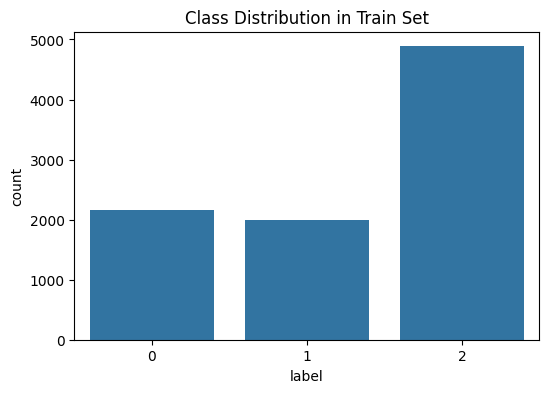

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=train_df["label"])
plt.title("Class Distribution in Train Set")
plt.show()

# Visualizing a few samples

Train sample images:


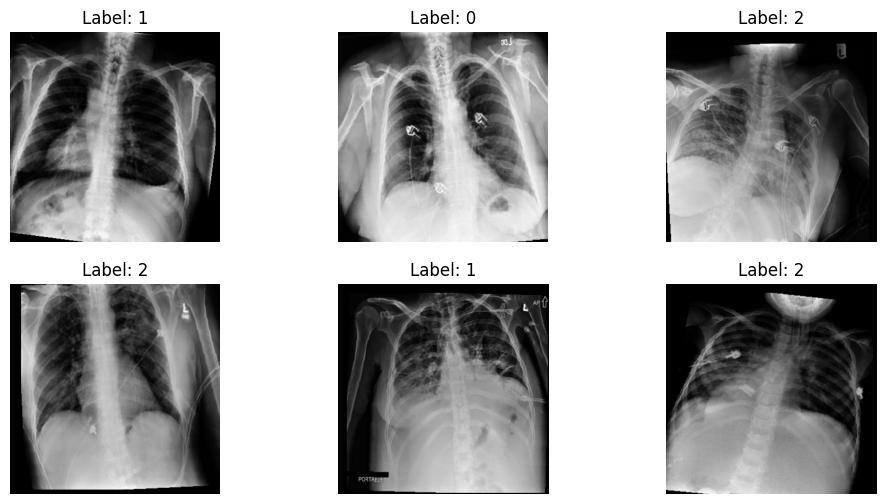


Validation sample images:


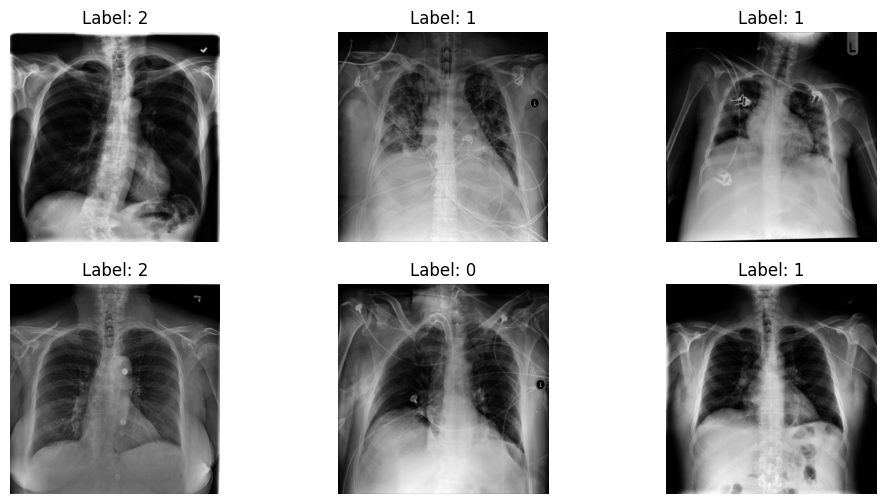

In [7]:
def show_samples(dataset, n=6):
    idxs = random.sample(range(len(dataset)), n)
    imgs = []
    labels = []

    for idx in idxs:
        img, label = dataset[idx]
        imgs.append(img.permute(1, 2, 0).numpy())
        labels.append(label)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

print("Train sample images:")
show_samples(train_dataset)
print()
print("Validation sample images:")
show_samples(val_dataset)

# Sanity Check

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=True)

device = torch.device(cfg["training"]["device"])

model = create_model(
    pretrained=cfg["model"]["pretrained"],
    num_classes=cfg["model"]["num_classes"]
).to(device)

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)

print("Batch shape:", images.shape)
print("Output shape:", outputs.shape)

Batch shape: torch.Size([16, 1, 380, 380])
Output shape: torch.Size([16, 3])


In [10]:
cfg["training"]["lr"]

'1e-4'

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
import copy
import os

device = torch.device(cfg["training"]["device"] if torch.cuda.is_available() else "cpu")

print("Training on:", device)

model = create_model(
    num_classes=cfg["model"]["num_classes"],
    pretrained=cfg["model"]["pretrained"],
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=float(cfg["training"]["lr"]),
    weight_decay=float(cfg["training"]["weight_decay"])
)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

num_epochs = cfg["training"]["epochs"]
patience = cfg["training"]["early_stopping_patience"]

Training on: cuda


In [14]:
best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # --------------------
    #     TRAIN
    # --------------------
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_total += labels.size(0)
        running_correct += preds.eq(labels).sum().item()

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # --------------------
    #     VALIDATION
    # --------------------
    model.eval()
    val_loss_tot, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_tot += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()

    val_loss = val_loss_tot / val_total
    val_acc = val_correct / val_total

    # Log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"Train Loss {train_loss:.4f} | Acc {train_acc:.4f} || "
        f"Val Loss {val_loss:.4f} | Acc {val_acc:.4f}"
    )

    # Scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"⭐ New best val_acc: {best_val_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("⛔ Early stopping triggered.")
            break


===== Epoch 1/20 =====


Training:   0%|          | 0/565 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
!mkdir -p data
!touch data/.gitkeep

In [23]:
!git add .gitignore data/.gitkeep
!git commit -m "Ignore dataset contents but keep data folder"

[main 7f972fe] Ignore dataset contents but keep data folder
 2 files changed, 6 insertions(+)
 create mode 100644 data/.gitkeep


In [24]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (5/5), 478 bytes | 59.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/valbad/chestxray-efficientnet.git
   3b70d35..7f972fe  main -> main


In [25]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   configs/default.yaml
	deleted:    notebooks/00_setup_and_training.ipynb
	deleted:    notebooks/01_visualization_and_inference.ipynb
	modified:   scripts/run_training.py
	modified:   src/data/dataset.py
	modified:   src/data/transforms.py
	modified:   src/models/efficientnet_b4.py
	deleted:    src/training/early_stopping.py
	deleted:    src/training/evaluation.py
	deleted:    src/training/train_loop.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	notebooks/chestxray_training_and_inference.ipynb
	scripts/download_dataset.py
	src/data/check_data.py
	src/data/download.py
	src/utils/

no changes added to commit (use "git add" and/or "git commit -a")


In [26]:
!git add .

In [27]:
!git commit -m "WIP: data pipeline, transforms, model training integration"

[main a5fb55f] WIP: data pipeline, transforms, model training integration
 15 files changed, 672 insertions(+)
 delete mode 100644 notebooks/00_setup_and_training.ipynb
 delete mode 100644 notebooks/01_visualization_and_inference.ipynb
 create mode 100644 notebooks/chestxray_training_and_inference.ipynb
 create mode 100644 scripts/download_dataset.py
 create mode 100644 src/data/check_data.py
 create mode 100644 src/data/download.py
 delete mode 100644 src/training/early_stopping.py
 delete mode 100644 src/training/evaluation.py
 delete mode 100644 src/training/train_loop.py
 create mode 100644 src/utils/env.py


In [29]:
!git reset --soft HEAD~1

In [30]:
!git reset HEAD notebooks/chestxray_training_and_inference.ipynb

In [31]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   configs/default.yaml
	deleted:    notebooks/00_setup_and_training.ipynb
	deleted:    notebooks/01_visualization_and_inference.ipynb
	new file:   scripts/download_dataset.py
	modified:   scripts/run_training.py
	new file:   src/data/check_data.py
	modified:   src/data/dataset.py
	new file:   src/data/download.py
	modified:   src/data/transforms.py
	modified:   src/models/efficientnet_b4.py
	deleted:    src/training/early_stopping.py
	deleted:    src/training/evaluation.py
	deleted:    src/training/train_loop.py
	new file:   src/utils/env.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	notebooks/



In [28]:
!git push

Enumerating objects: 31, done.
Counting objects: 100% (27/27), done.
Delta compression using up to 12 threads
Compressing objects: 100% (16/16), done.
Writing objects: 100% (19/19), 498.54 KiB | 7.02 MiB/s, done.
Total 19 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote:      https://docs.github.com/code-security/secret-scanning/working-with-secret-scanning-and-push-protection/working-with-push-protection-from-the-command-line#resolving-a-blocked-push
remote:     
remote:     
remote:       —— GitHub Personal Access Token ——————————————————————
remote:        